In [25]:
import mclimate as mclim
import farray as fa
import importlib
import numpy as np
import bottleneck
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mc
importlib.reload(mc)

<module 'matplotlib.colors' from 'C:\\Users\\tman1_000\\Anaconda3\\lib\\site-packages\\matplotlib\\colors.py'>

In [2]:
date = '2016012100'
plt.style.use('seaborn-colorblind')

In [20]:
gefs_mean = xr.open_dataset('../../espr/reforecast/v12/slp_mean_djf.nc',chunks={'time':10})
gefs_mean = gefs_mean.sel(date=date).sel(time=54)
gefs_mean

<xarray.Dataset>
Dimensions:    (latitude: 161, longitude: 561)
Coordinates:
  * longitude  (longitude) float32 180.0 180.2 180.5 180.8 ... 319.5 319.8 320.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 20.5 20.25 20.0
    time       float64 54.0
    date       <U10 '2016012100'
Data variables:
    msl        (latitude, longitude) float32 dask.array<chunksize=(161, 561), meta=np.ndarray>

In [21]:
gefs_sprd = xr.open_dataset('../../espr/reforecast/v12/slp_sprd_djf.nc',chunks={'time':10})
gefs_sprd = gefs_sprd.sel(date=date).sel(time=54)
gefs_sprd

<xarray.Dataset>
Dimensions:    (latitude: 161, longitude: 561)
Coordinates:
  * longitude  (longitude) float32 180.0 180.2 180.5 180.8 ... 319.5 319.8 320.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 20.5 20.25 20.0
    time       float64 54.0
    date       <U10 '2016012100'
Data variables:
    msl        (latitude, longitude) float32 dask.array<chunksize=(161, 561), meta=np.ndarray>

In [26]:
mclimate = mclim.MClimate('2016-01-21','G:/Projects/espr/reforecast/v12','slp',54,v12=True,dask_enabled=True)

In [27]:
mclimate.client

Client Scheduler: tcp://127.0.0.1:55458 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 20 Memory: 34.27 GB


In [28]:
mcli = mclimate.generate()

In [29]:
mcli_sprd = mclimate.generate(stat='sprd')

In [30]:
# percentiles = percentile(mc_mu, gefs_mean)
# subset = subset_sprd(percentiles, mc_std)
# hsa_final = hsa_transform(gefs_sprd, subset)

In [31]:
percentile = mcli.load().rank('time')/len(mcli['time'])

In [32]:
new_perc = percentile.where(np.logical_and(percentile >= percentile.isel(time=-1)-0.05, percentile <= percentile.isel(time=-1)+0.05),drop=True)

In [33]:
mcli_sprd = mcli_sprd.where(~np.isnan(new_perc),drop=True)

In [34]:
mcli_sprd = mcli_sprd.chunk({'time':10})

In [35]:
mcli_sprd

<xarray.Dataset>
Dimensions:    (latitude: 161, longitude: 561, time: 600)
Coordinates:
  * longitude  (longitude) float32 180.0 180.2 180.5 180.8 ... 319.5 319.8 320.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 20.5 20.25 20.0
    fhour      float64 54.0
  * time       (time) datetime64[ns] 2000-01-11 2000-01-12 ... 2019-12-09
    timestr    (time) <U42 dask.array<chunksize=(10,), meta=np.ndarray>
Data variables:
    msl        (time, latitude, longitude) float32 dask.array<chunksize=(10, 161, 561), meta=np.ndarray>

In [36]:
subset_vals = (gefs_sprd - mcli_sprd.mean('time'))/mcli_sprd.std('time')
subset_vals = (0.99-(-0.99))*(subset_vals-subset_vals.min(['latitude','longitude']))/(subset_vals.max(['latitude','longitude'])-subset_vals.min(['latitude','longitude'])) + -0.99
subset_vals = np.arctanh(subset_vals)

In [37]:
subset_vals

<xarray.Dataset>
Dimensions:    (latitude: 161, longitude: 561)
Coordinates:
  * longitude  (longitude) float32 180.0 180.2 180.5 180.8 ... 319.5 319.8 320.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 20.5 20.25 20.0
    time       float64 54.0
    date       <U10 '2016012100'
    fhour      float64 54.0
Data variables:
    msl        (latitude, longitude) float32 dask.array<chunksize=(161, 561), meta=np.ndarray>

In [38]:
subset_vals.where(np.abs(subset_vals) > 0.5).msl

<xarray.DataArray 'msl' (latitude: 161, longitude: 561)>
dask.array<where, shape=(161, 561), dtype=float32, chunksize=(161, 561), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 180.0 180.2 180.5 180.8 ... 319.5 319.8 320.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 20.5 20.25 20.0
    time       float64 54.0
    date       <U10 '2016012100'
    fhour      float64 54.0

In [39]:
n=35
x = 0.5
cmap = plt.cm.RdBu_r
lower = cmap(np.linspace(0, x, n))
white = np.ones((80-2*n,4))
upper = cmap(np.linspace(1-x, 1, n))
colors = np.vstack((lower, white, upper))
tmap = mc.LinearSegmentedColormap.from_list('map_white', colors)

C:\Users\tman1_000\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


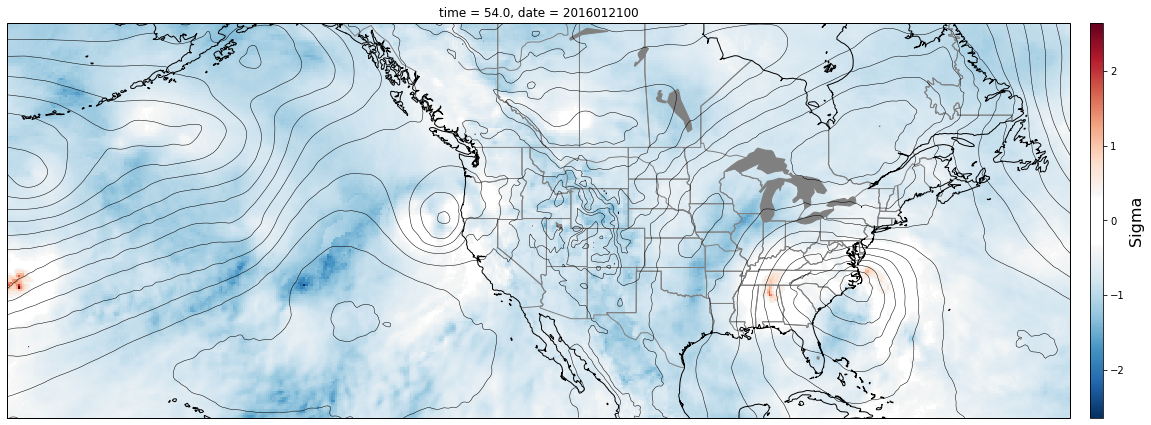

In [40]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=ccrs.Miller())
ax.add_feature(cf.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines', '50m',
    edgecolor='gray', facecolor='none'))
ax.add_feature(cf.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines', '50m',
    edgecolor='gray', facecolor='none'))        
ax.add_feature(cf.LAKES, facecolor='gray')
ax.add_feature(cf.BORDERS, edgecolor='gray')
ax.add_feature(cf.RIVERS, edgecolor='gray')
ax.add_feature(cf.OCEAN, facecolor='gray')
ax.set_extent([-180,-50,20,60],crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
subset_vals_fix = subset_vals
subset_vals_fix['longitude'] = (subset_vals_fix['longitude']  + 180) % 360 - 180
subset_vals_fix  = subset_vals_fix.sortby(subset_vals_fix['longitude'] )
c = subset_vals_fix.msl.plot.imshow(ax=ax,
                                     transform=ccrs.PlateCarree(),
                                    cmap=tmap,
                                    add_colorbar=False)
(gefs_mean.msl/100).plot.contour(ax=ax,
                    colors = 'k',
                    transform=ccrs.PlateCarree(),
                    levels=np.arange(900,1100,4),
                    add_colorbar=False,
                    linewidths=0.5)
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.001, axes_class=plt.Axes, aspect=30)
fig.add_axes(ax_cb)
cb = plt.colorbar(c, cax=ax_cb)
cb.set_label(label='Sigma',fontsize=16)
plt.show()

C:\Users\tman1_000\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


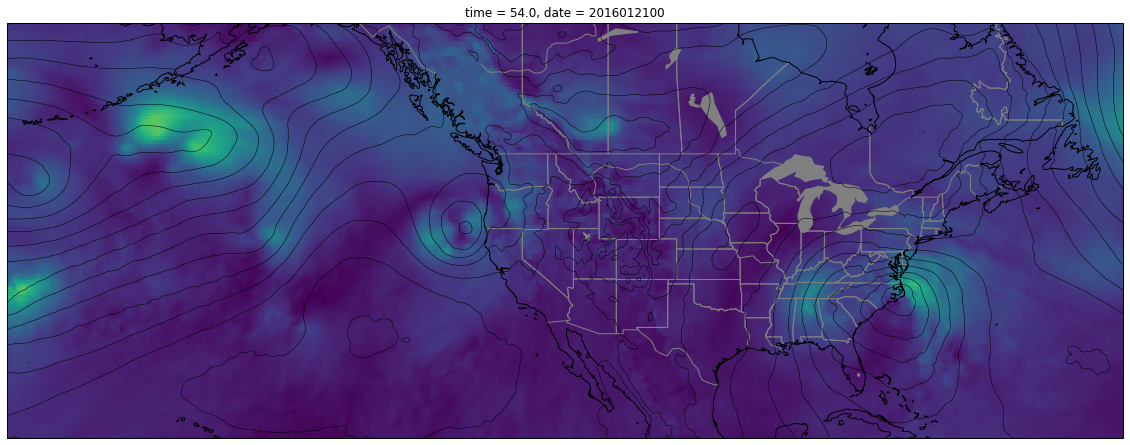

In [41]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=ccrs.Miller())
ax.add_feature(cf.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines', '50m',
    edgecolor='gray', facecolor='none'))
ax.add_feature(cf.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines', '50m',
    edgecolor='gray', facecolor='none'))        
ax.add_feature(cf.LAKES, facecolor='gray')
ax.add_feature(cf.BORDERS, edgecolor='gray')
ax.add_feature(cf.RIVERS, edgecolor='gray')
ax.add_feature(cf.OCEAN, facecolor='gray')
ax.set_extent([-180,-50,20,60],crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
subset_vals_fix = gefs_sprd
subset_vals_fix['longitude'] = (subset_vals_fix['longitude']  + 180) % 360 - 180
subset_vals_fix  = subset_vals_fix.sortby(subset_vals_fix['longitude'] )
c = subset_vals_fix.msl.plot.imshow(ax=ax,
                             transform=ccrs.PlateCarree(),
                                add_colorbar=False,cmap='viridis')
(gefs_mean.msl/100).plot.contour(ax=ax,
                    colors = 'k',
                    transform=ccrs.PlateCarree(),
                    levels=np.arange(900,1100,4),
                    add_colorbar=False,
                    linewidths=0.5)
# divider = make_axes_locatable(ax)
# ax_cb = divider.new_horizontal(size="5%", pad=0.001, axes_class=plt.Axes, aspect=30)
# fig.add_axes(ax_cb)
# cb = plt.colorbar(c, cax=ax_cb)
# cb.set_label(label='Sigma',fontsize=16)
plt.show()